In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import layers, backend as K
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
print(df.tail())
print(df.info())
df.drop(['date'], axis = 1, inplace=True)

            date   meantemp    humidity  wind_speed  meanpressure
1457  2016-12-28  17.217391   68.043478    3.547826   1015.565217
1458  2016-12-29  15.238095   87.857143    6.000000   1016.904762
1459  2016-12-30  14.095238   89.666667    6.266667   1017.904762
1460  2016-12-31  15.052632   87.000000    7.325000   1016.100000
1461  2017-01-01  10.000000  100.000000    0.000000   1016.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
None


In [3]:
dftest = pd.read_csv('DailyDelhiClimateTest.csv')
print(dftest.head())
dftest.drop(['date'], axis = 1, inplace=True)

         date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333


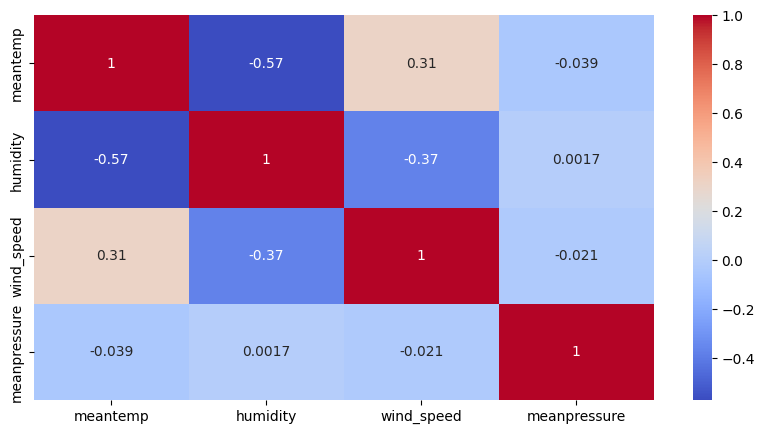

In [4]:
correlation = df.corr()
plt.subplots(figsize=(10,5), dpi=100)
sns.heatmap(correlation, annot=True, cmap='coolwarm');

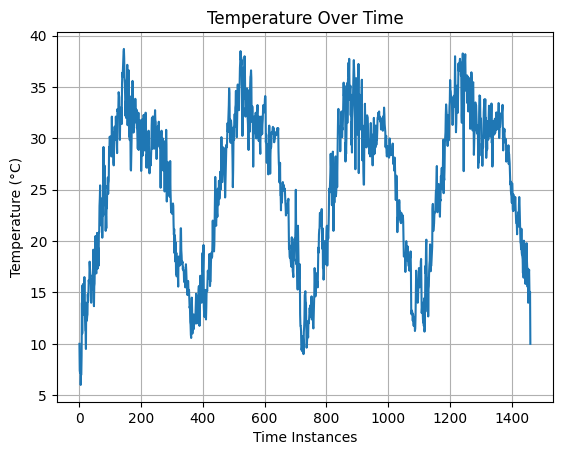

In [5]:
plt.plot(df.index, df['meantemp'], label = 'Temperature', linestyle='-')
# Format the plot
plt.title('Temperature Over Time')
plt.xlabel('Time Instances')
plt.ylabel('Temperature (°C)')
#plt.legend()
plt.grid(True)

# Display the plot
plt.show()

**Building Train dataset**<br>
Here we are trying to do temperature prediction by looking at the past 7 days data, so we are trying to do a many to one rnn task. So for the input we will have 7 days data and the prediction will be of the 8th day.

Here we are taking temperature, humidity, windspeed and pressure of previous 7 days to predict 8th day temperature :

[[[temp1, humid1, wind1, pressure1],[2],[3],[4],[5],[6],[7]]] -> [temp8]

[[[2],[3],[4],[5],[6],[7],[8]]] -> [temp9]

[[[3],[4],[5],[6],[7],[8],[9]]] -> [temp10]

So the input to the rnn will be a 3D tensor with dimensions as (batch_size, time_steps, features) here batch_size can be 32, time_steps are 7 and features 4.

In the following cell we will define a function to convert our data into the input format for rnn.

In [6]:
def datatoXY(prearr, arr, windsize = 7) : # prearr -> preprocessed features, arr -> not preprocessed output feature
    x = []
    y = []
    for i in range(len(arr) - windsize) :#leaves windsize elements so in last iteration current element plus windsize - 1 for x and last element for Y 
        row = [r for r in prearr[i : i + windsize]] #row is 2D containing values from i to i + windsize - 1
        x.append(row)
        y.append(arr[i + windsize]) #ind is the index of feature to be predicted in df
    return np.array(x), np.array(y)

In one stride, windsize + 1 elements are needed thus total elements in final array is (total_init - (windsize + 1) + 1) = total_init - windsize (this calc is similar to cnn stride calculations for convolution filters). 

In [7]:
def datatoXYnoInp(prearr, arr, windsize = 7, ind = 0) : #if dont want to include predicting feature as input
    x = []
    y = []
    for i in range(len(arr) - windsize + 1) :#leaves windsize - 1 elements so in last iteration current element plus windsize - 1 for x and last element for Y
        row = [r for r in prearr[i : i + windsize]] #row is 2D containing values from i to i + windsize - 1
        x.append(row)
        y.append(arr[i + windsize - 1]) #ind is the index of feature to be predicted in df
    return np.array(x), np.array(y)

In above if input is not to be considered then we can use the current layer and some previous layer to predict the current layer feature needed to be predicted.

[[[humid1, wind1, pressure1],[2],[3],[4],[5],[6],[7]]] -> [temp7]

[[[2],[3],[4],[5],[6],[7],[8]]] -> [temp8]

[[[3],[4],[5],[6],[7],[8],[9]]] -> [temp9]

In one stride, windsize elements are needed thus total elements in final array is (total_init - (windsize) + 1) = total_init - windsize + 1 (this calc is similar to cnn stride calculations for convolution filters). 

Preprocessing using standard scaler, want to preprocess the input features in such a way that the output feature to be predicted is not preprocessed, that's why we have to preserve meantemp column so it can be used for checking prediction, while simultaneously all the previous days meantemp should be preprocessed. 

In [8]:
data = df.values
dtest = dftest.values

# Column vectors for temperature, which will not be preprocessed
data_nopre = data[:, 0]
dt_nopre = dtest[:, 0]

data_nopre.shape, dt_nopre.shape

((1462,), (114,))

In [9]:
sc = StandardScaler()

data_scaled = sc.fit_transform(data)
dtest_scaled = sc.transform(dtest)

In [10]:
data_scaled[0], dtest_scaled[0], data_nopre[0]

(array([-2.10950001,  1.41543887, -1.49169876,  0.02532119]),
 array([-1.30452123,  1.49713608, -0.89006431, -5.28447825]),
 10.0)

In [11]:
X_train, y_train = datatoXY(data_scaled, data_nopre)
X_test, y_test = datatoXY(dtest_scaled, dt_nopre)

# Total trainig samples were : 1462, windsize = 7 -> 1462 - 7 = 1455
# Total test samples were : 114, windsize = 7 -> 114 - 7 = 107
# This is because we leave the first windsize samples to for predicting the next day
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1455, 7, 4), (1455,), (107, 7, 4), (107,))

In [12]:
timesteps, features = X_train.shape[1], X_train.shape[2]
timesteps, features

(7, 4)

In [13]:
X_train[0], y_train[0]

(array([[-2.10950001,  1.41543887, -1.49169876,  0.02532119],
        [-2.46345392,  1.86282836, -0.83819598,  0.03716186],
        [-2.49521901,  1.5645687 , -0.47562621,  0.04197213],
        [-2.29101484,  0.63002175, -1.2212334 ,  0.03364666],
        [-2.65404448,  1.55462671, -0.68030269,  0.02994645],
        [-2.51790837,  1.31403058, -1.16714033,  0.03827192],
        [-2.51790837,  1.06349246, -0.11013249,  0.04937255]]),
 8.857142857142858)

In [14]:
data_nopre[7]

8.857142857142858

From the above cells we can see that the first 7 (windsize) set of features corresponds to one training sample and that are used to predict the tempertaure of the 8th day which corresponds to one test sample.

### Building the Model
- https://philipperemy.github.io/keras-stateful-lstm/

In [15]:
K.clear_session()

model = keras.Sequential([
    layers.SimpleRNN(64, return_sequences=True, input_shape = [timesteps, features]), #here 7 and 4
    layers.SimpleRNN(32),
    layers.Dense(16, activation='relu'),#as the return_sequence = false for above layer the following dense layers will only be applied to the last timestep
    layers.Dense(1, activation='linear')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 7, 64)             4416      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,065
Trainable params: 8,065
Non-trainable params: 0
_________________________________________________________________


For dimensions of above model :

 - Layer 1 SimpleRNN : input - 4, neurons - 64 <br>
64x4 + 64(bias) + (64x64) for passing to next timestep total = 4416 parameters and output of (7x32).<br>
If return_sequence would have been false then only last timestep output would have been passed so then output (1x32).

- Layer 2 SimpleRNN : input - 64, neurons - 32 <br>
(64x32) + 32(bias) + (32x32) for passing to next timestep total = 3104.<br>
return_sequence is false thus output (1x32).

- Layer 3 Dense : input - 32, neurons - 16 <br>
(32x16) + 16(bias) total = 528 and output of (16) <br>

- Layer 4 Dense : input - 16, neurons - 1 <br>
(16x1) + 1 total 17 and output of (1)

TimeDistributedDense applies a same dense to every time step during GRU/LSTM Cell unrolling. So the error function will be between predicted label sequence and the actual label sequence. (Which is normally the requirement for sequence to sequence labeling problems).

However, with return_sequences=False, Dense layer is applied only once at the last cell. This is normally the case when RNNs are used for classification problem. If return_sequences=True then Dense layer is applied to every timestep just like TimeDistributedDense.

In [16]:
model.compile(
    optimizer = 'adam',
    loss = 'mse',
    metrics=[keras.metrics.RootMeanSquaredError()])

#early stopping done so that the model is not overfitted, it stops further training when it sees that validation error is increasing
early_stopping = keras.callbacks.EarlyStopping(
    min_delta = 0.00001, # minimium amount of change to count as an improvement
    patience = 16, # how many epochs to wait before stopping
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size = 10,
    epochs = 500,
    callbacks = [early_stopping]

)

Epoch 1/500
146/146 [==============================] - 6s 23ms/step - loss: 497.3258 - root_mean_squared_error: 22.3008 - val_loss: 114.8179 - val_root_mean_squared_error: 10.7153
Epoch 2/500
146/146 [==============================] - 3s 22ms/step - loss: 93.7901 - root_mean_squared_error: 9.6845 - val_loss: 60.3586 - val_root_mean_squared_error: 7.7691
Epoch 3/500
146/146 [==============================] - 3s 23ms/step - loss: 45.2079 - root_mean_squared_error: 6.7237 - val_loss: 27.3088 - val_root_mean_squared_error: 5.2258
Epoch 4/500
146/146 [==============================] - 3s 22ms/step - loss: 14.1134 - root_mean_squared_error: 3.7568 - val_loss: 28.4132 - val_root_mean_squared_error: 5.3304
Epoch 5/500
146/146 [==============================] - 3s 23ms/step - loss: 13.3872 - root_mean_squared_error: 3.6589 - val_loss: 15.3923 - val_root_mean_squared_error: 3.9233
Epoch 6/500
146/146 [==============================] - 3s 21ms/step - loss: 18.8046 - root_mean_squared_error: 4.336

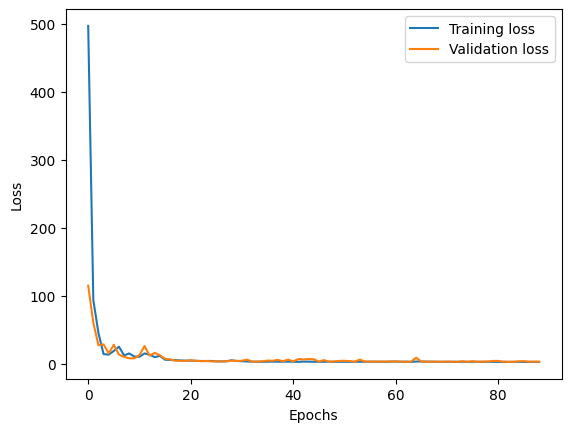

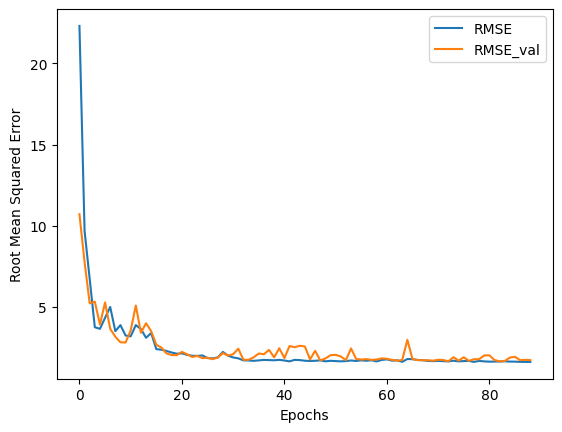

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']
rmse = history.history['root_mean_squared_error']
rmse_val = history.history['val_root_mean_squared_error']

plt.plot(loss, label = 'Training loss')
plt.plot(val_loss, label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

plt.plot(rmse, label = 'RMSE')
plt.plot(rmse_val, label = 'RMSE_val')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [18]:
y_pred = model.predict(X_test, verbose = 0)

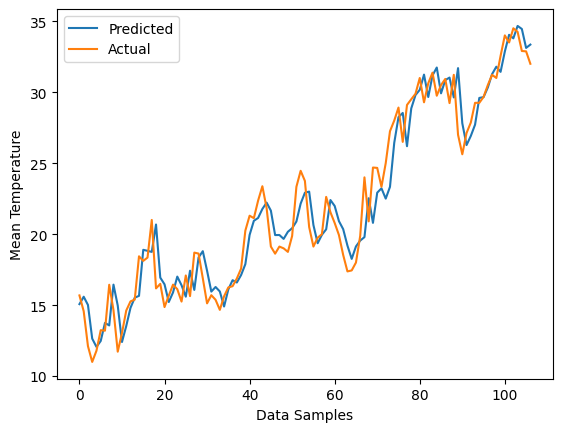

In [19]:
plt.plot(y_pred, label = 'Predicted')
plt.plot(y_test, label = 'Actual')
plt.ylabel('Mean Temperature')
plt.xlabel('Data Samples')
plt.legend()
plt.show()

The predicted mean temperature closely resembles the true mean temperature.